<a href="https://colab.research.google.com/github/alex-smith-uwec/NLP_Spring2025/blob/main/reverse_painting_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reverse Image Search featuring Impressionist Paintings

It's easy to get your own reverse-image search up and running locally with a vector database. We use [Milvus Lite](https://milvus.io/docs/milvus_lite.md) and [PyTorch](https://pytorch.org/) to build a local reverse image search using the Impressionist-Classifier Dataset found on [Kaggle](https://www.kaggle.com/datasets/delayedkarma/impressionist-classifier-data).

We start by importing the necessary libraries:

In [ ]:
! pip install pymilvus   torch  gdown  torchvision  tqdm  milvus -q

In [ ]:
# Uninstall the current version of grpcio
!pip uninstall grpcio -y

# Install a compatible version of grpcio
!pip install 'grpcio<=1.60.0,>=1.49.1'
##Restart runtime!!

Next, we download the dataset using `gdown` to download it from a publicly hosted Google Drive and `zipfile` to unzip the images.

In [ ]:
import gdown
import zipfile

url = 'https://drive.google.com/uc?id=1OYDHLEy992qu5C4C8HV5uDIkOWRTAR1_'
output = './paintings.zip'
gdown.download(url, output)

with zipfile.ZipFile("./paintings.zip","r") as zip_ref:
    zip_ref.extractall("./paintings")

Downloading...
From (original): https://drive.google.com/uc?id=1OYDHLEy992qu5C4C8HV5uDIkOWRTAR1_
From (redirected): https://drive.google.com/uc?id=1OYDHLEy992qu5C4C8HV5uDIkOWRTAR1_&confirm=t&uuid=15d2b641-c391-4fc1-a921-7c3fbd1c1f49
To: /content/paintings.zip
100%|██████████| 2.35G/2.35G [00:51<00:00, 45.4MB/s]


Once we've downloaded all the images, we need to set up some parameters that we'll use later on to work with our vector database.

In [ ]:
# Collection Setup Parameters
COLLECTION_NAME = 'image_search'  # Collection name
DIMENSION = 2048  # Embedding vector size in this example

# Inference Arguments
BATCH_SIZE = 128
TOP_K = 3

Let's start our local Vector Database instance with Milvus Lite

In [ ]:
from milvus import default_server
from pymilvus import connections, utility

# (OPTIONAL) Set if you want store all related data to specific location
# Default location:
#   %APPDATA%/milvus-io/milvus-server on windows
#   ~/.milvus-io/milvus-server on linux
# default_server.set_base_dir('milvus_data')

# (OPTIONAL) if you want cleanup previous data
# default_server.cleanup()

# Start your milvus server
default_server.start()

# Now you could connect with localhost and the given port
# Port is defined by default_server.listen_port
connections.connect(host='127.0.0.1', port=default_server.listen_port)

# Check if the server is ready.
print(utility.get_server_version())

v2.3.5-lite


With our server up, we're ready to get started. We start by defining the vector database schema and establishing a collection. Each entry in our collection features three fields. First, an `id` for regular querying, next a filepath to identify where the image is stored locally, and lastly, the embedding that we use for similarity search.

In [ ]:
from pymilvus import FieldSchema, CollectionSchema, DataType, Collection

# Check that the collection does not yet exist
if utility.has_collection(COLLECTION_NAME):
    utility.drop_collection(COLLECTION_NAME)

fields = [
    FieldSchema(name='id', dtype=DataType.INT64, is_primary=True, auto_id=True),
    FieldSchema(name='filepath', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='image_embedding', dtype=DataType.FLOAT_VECTOR, dim=DIMENSION)
]
schema = CollectionSchema(fields=fields)
collection = Collection(name=COLLECTION_NAME, schema=schema)

Once we have a connection to our vector database and an established collection, we create an index to search on. For this example, we use an IVF Flat index measured with the L2 Norm and 128 cluster units (`nlist`).

Click here to learn more about [vector indexes](https://medium.com/vector-database/how-to-choose-an-index-in-milvus-4f3d15259212).

In [ ]:
index_params = {
    "index_type": "IVF_FLAT",
    "metric_type": "L2",
    "params": {"nlist": 128},
}
collection.create_index(field_name="image_embedding", index_params=index_params)
collection.load()

Now let's get the embeddings. We use the [ResNet50 model from PyTorch](https://pytorch.org/vision/master/models/generated/torchvision.models.resnet50.html) to get the embeddings. Normally, the last layer of the ResNet50 model outputs classifications for a dataset. In our case, we need the embeddings, not the classifications, so we remove the last layer.

In [ ]:
import glob
paths = glob.glob('./paintings/paintings/**/*.jpg', recursive=True)
print(len(paths))

4978


In [ ]:
# run this before importing th resnet50 model if you run into an SSL certificate URLError
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
import torch
# Load the embedding model with the last layer removed
# the last layer is the classification layer, the embeddings are the layer right before
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 145MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


At this point we have a local Milvus instance running, the data for this example project, and the model we need to get some embeddings. Uploading the data into the vector database as a collection and getting it indexed is the next step. First, we preprocess the data to fit the data that the [ResNet50 Model](https://pytorch.org/vision/master/models/generated/torchvision.models.resnet50.html) was trained on (seen on the bottom of the page). Then we batch the data and "upload" it to our vector database.

*the second block of this step takes a while to run (about 12 minutes on a 16GB RAM M1 Mac), we are running almost 5000 images through ResNet50, now would be a good time to grab a snack or something to drink :)*

In [ ]:
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
def embed(data):
    with torch.no_grad():
        output = model(torch.stack(data[0])).squeeze()
        collection.insert([data[1], output.tolist()])

data_batch = [[], []]

for path in tqdm(paths):
    im = Image.open(path).convert('RGB')
    data_batch[0].append(preprocess(im))
    data_batch[1].append(path)
    if len(data_batch[0]) % BATCH_SIZE == 0:
        embed(data_batch)
        data_batch = [[], []]

if len(data_batch[0]) != 0:
    embed(data_batch)

collection.flush()

100%|██████████| 4978/4978 [30:24<00:00,  2.73it/s]


With our vector database populated, we are ready to perform a reverse image search. The second block in this section shows how you pick an image or set of images to reverse image search. For this example, we have two search patterns. The first one (commented out) shows how to search the provided test paintings. The second one shows how to reverse image search for a specific painting provided in the training set. In most cases, it's bad practice to use training data while doing any sort of validation, but this particular case confirms that we are returning the same image when performing a reverse image search an on image that exists in our vector database

In [ ]:
import time # for measuring how long the reverse image search takes
from matplotlib import pyplot as plt

In [ ]:
# modify `search_paths` to modify which images you reverse search

# the below example shows how to search for the most similar results to two images in the test set
# search_paths = glob.glob('./paintings/test_paintings/**/*.jpg', recursive=True)

# the below example shows how to search for a specific image in the training set
# we expect to get the same image back as the "most similar" image
search_paths = glob.glob('./paintings/paintings/training/training/Degas/213255.jpg', recursive=True)
len(search_paths)

1

In [ ]:
def embed(data):
    with torch.no_grad():
        ret = model(torch.stack(data))
        if len(ret) > 1:
            return ret.squeeze().tolist()
        else:
            return torch.flatten(ret, start_dim=1).tolist()
data_batch = [[], []]

for path in search_paths:
    im = Image.open(path).convert('RGB')
    data_batch[0].append(preprocess(im))
    data_batch[1].append(path)

embeds = embed(data_batch[0])
start = time.time()
res = collection.search(embeds,
                        anns_field='image_embedding',
                        param={"metric_type": "L2",
                               "params": {"nprobe": 10}},
                        limit=TOP_K,
                        output_fields=['filepath'])
finish = time.time()
print(finish - start)

0.020355939865112305


We can plot the images for a visual.

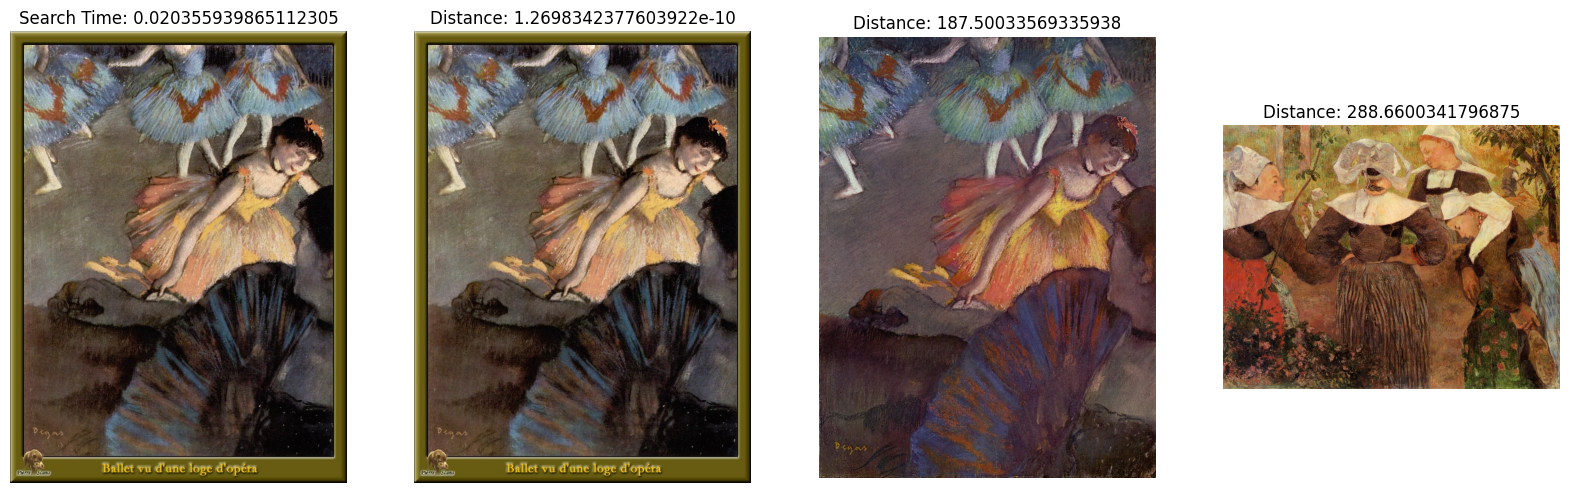

In [ ]:
f, axarr = plt.subplots(len(data_batch[1]), TOP_K + 1, figsize=(20, 10), squeeze=False)

# print(type(res))

for hits_i, hits in enumerate(res):
    axarr[hits_i][0].imshow(Image.open(data_batch[1][hits_i]))
    axarr[hits_i][0].set_axis_off()
    axarr[hits_i][0].set_title('Search Time: ' + str(finish - start))
    for hit_i, hit in enumerate(hits):
        axarr[hits_i][hit_i + 1].imshow(Image.open(hit.entity.get('filepath')))
        axarr[hits_i][hit_i + 1].set_axis_off()
        axarr[hits_i][hit_i + 1].set_title('Distance: ' + str(hit.distance))

# Save the search result in a separate image file alongside your script.
plt.savefig('reverse_search_result.png')

We can also see which images were classified as the most similar.

In [ ]:
for hits_i, hits in enumerate(res):
    for hit_it, hit in enumerate(hits):
        print(hit.entity)

id: 449282193079669459, distance: 1.2698342377603922e-10, entity: {'filepath': './paintings/paintings/training/training/Degas/213255.jpg'}
id: 449282193079669630, distance: 187.50033569335938, entity: {'filepath': './paintings/paintings/training/training/Degas/213310.jpg'}
id: 449282193079669803, distance: 288.6600341796875, entity: {'filepath': './paintings/paintings/training/training/Gauguin/190574.jpg'}


Finally, we want to clean up our Milvus instance.

In [ ]:
# cleanup
default_server.stop()